In [1]:
import numpy as np 
from scipy.special import rel_entr
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns 

Declaremos una distribución y verifiquemos que la distribución es lo que esperamos 

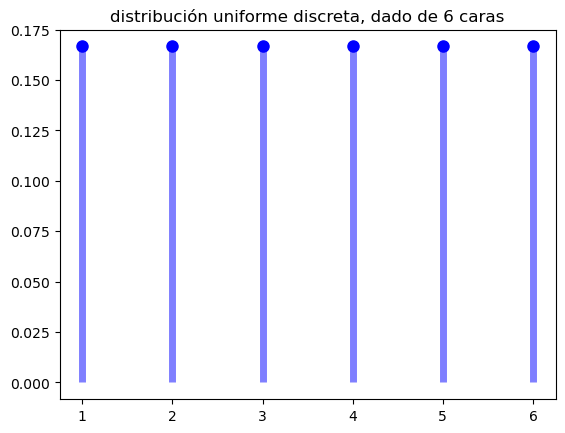

In [2]:
low, high = 1, 7

fig, ax = plt.subplots(1, 1)
x = np.arange(stats.randint.ppf(0.01, low, high+1),
              stats.randint.ppf(0.99, low, high+1))

ax.plot(x, stats.randint.pmf(x, low, high), 'bo', ms=8, label='randint pmf')
ax.vlines(x, 0, stats.randint.pmf(x, low, high), colors='b', lw=5, alpha=0.5)
plt.title("distribución uniforme discreta, dado de %d caras"%(high-low))
plt.show()

A continuación declaramos 3 funciones:
 - rel_freq: calcula la frecuencia relativa de una muestra, el vector devuelto tiene tantos o menos elementos como caras el dado, no hay frecuencias nulas 
 - experimento_muestral: la versión original, calcula el promedio de las frecuencias en un size-nuestreo 
 - every_freq: Similar a rel_freq, entregas las frecuencias relativas, pero en el orden, si una frecuencia es 0, es porque no se visitó ese estado/cara del dado

In [3]:

def rel_freq(sample, values=False):
    '''Funcion que devuelve la frecuancia relativa de los elementos de x '''
       
    freqs = [(value, np.count_nonzero(sample==value) / len(sample)) for value in set(sample)] 
    
    if values: 
        return freqs
    else: 
        return np.array(freqs)[:,1]
    

def experimento_muestras(low, high, size=15, random_state=42):
    '''
    Función aleatoria que devuelve el resultado de simular el  experimento *una vez*.
    El resultado es distinto cada vez que llamamos a la función.
    El resultado es un promedio a partir de una muestra de tamaño _size_
    '''
    sample = stats.randint.rvs(low, high, size=size, random_state=random_state)
    freqs = [ np.count_nonzero(sample==value) / len(sample) for value in set(sample)] 
    
    return np.mean(freqs) #ignore

def every_freq(low, high, size=15, random_state=42):
    '''La función toma un vector que podría, potencialmente ser más corto y lo inserta en una más largo
    (de largo el numero de enteros en al distro uniforme), de tal manera de que los elementos faltantes tengan frecuancia 0'''
    
    sample = stats.randint.rvs(low, high, size=size, random_state=random_state)
    freqs = [(value, np.count_nonzero(sample==value) / len(sample)) for value in set(sample)] 
    
    l = sorted((freqs, np.zeros(high-low)), key=len)
    
    c = l[1].copy()
    
    for i in freqs:
        c[i[0]-1] += i[1]
    
    
    return np.array(c)   


Ahora usemos  un array (randomState) con semillas aleatorias para asegurarnos que no estamos repitiendo el ejercicios futilmente

- La función _stat.entropy(*a*,*b*)_ al igual que _rel_entr(*a*,*b*)_, entregan la entropía relativa entre distribuciones *a* y *b*, en ambos casos es necesario que *a* y *b* tengan elmismo largo
- n_sims= convierte las iteraciones(iter) en una matriz de *iter x (high-low)* con las frecuencias relativas de cada una de las iteraciones de tirar el dado _sample_size_ veces

In [4]:
# unif= stats.randint.pmf(x, low, high)
iter, sample_size= 1120, 50

randomState= set(stats.randint.rvs(0, 5000, size=iter, random_state=42))

iter= len(set(randomState))

# [sum(stat.entropy(every_freq(low, high, size=25, random_state=i), unif)) for i in randomState]
n_sims=np.stack([every_freq(low, high, size=sample_size, random_state=i) for i in randomState])

print("(%d iteraciones, lanzar el dado %d veces, %d estados/caras)="%(iter, sample_size ,(high-low)), n_sims.shape)

(999 iteraciones, lanzar el dado 50 veces, 6 estados/caras)= (999, 6)


Vale la pena preguntarnos, en las columna ¿ como distribuyen los datos? Beta cada columna, Dirichlet entre todas ellas. ¿Cómo distribuyen las filas? las filas deberían tender a ser uniformes en la medida que aumentamos *sample_size*. 

Para pocas caras, hagamos la gráfica

c:\Users\rodri\miniconda3\lib\site-packages\scipy\stats\_continuous_distns.py:707: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\rodri\miniconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\rodri\miniconda3\lib\site-packages\scipy\stats\_continuous_distns.py:707: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


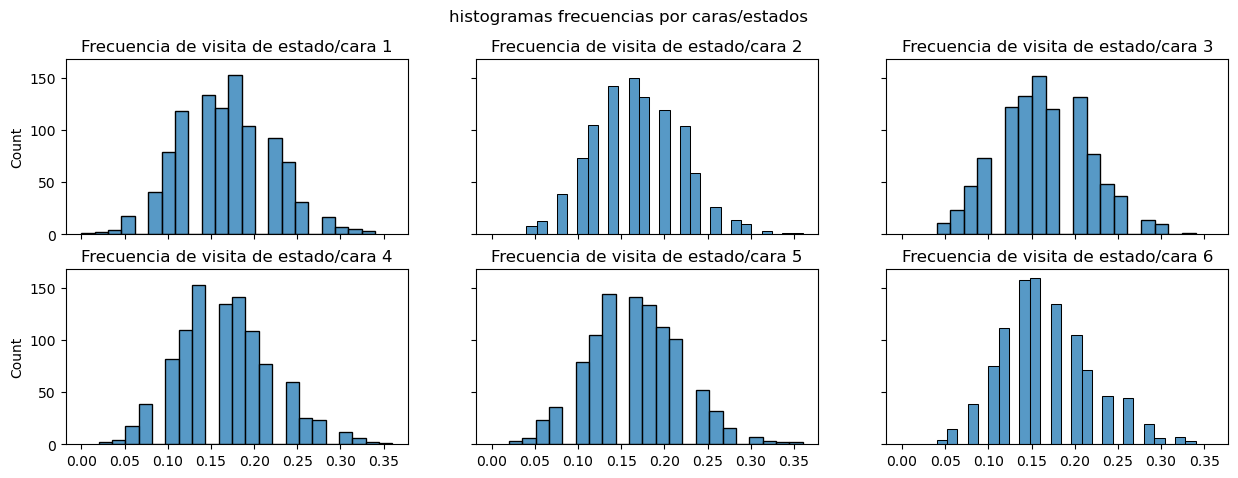

Promedio de cada estado=  [0.16758759 0.16810811 0.16388388 0.16700701 0.16662663 0.16678679]


In [5]:
fig, axes = plt.subplots(2, (high-low)//2, sharex=True, sharey=True, figsize=(15,5))
fig.suptitle('histogramas frecuencias por caras/estados')

for i in range((high-low)):
    [alpha, beta, _, _ ] = stats.beta.fit(n_sims[:,i]) #, floc=0)
        
    if i<(high-low)//2:
        hist=sns.histplot(data=n_sims[:,i], ax=axes[0,i])#, stat= "probability")
        
    else:
        hist=sns.histplot(data=n_sims[:,i], ax=axes[1,(i-(high-low)//2)])#, stat= "probability")
    #hist.set(title="alpha= %.2f, beta= %.2f"% (alpha, beta))
    hist.set(title="Frecuencia de visita de estado/cara %d"%(i+1))
    
plt.show()    
print("Promedio de cada estado= ", np.mean(n_sims, axis =0)) 


Si quisieramos usar la maquinaria para distribuciones normales, necesitamos promedios $\bar{X}$, ya que sabemos que $\bar{X}\sim N(\mu,\sigma^2)$.
*Idea: sacar los promedios para cada columna de n_sims y trabajar ahí*

### Verifiquemos que nuestro "dado" es justo, lo haremos haciendo uso de la prueba $\chi^2$. 

Para esto, calculemos, la cantidad esperada de veces que cada cara/estado debería haber salido para un dado justo, es decir, el número total de lanzamientos dividido por el número de lados. Llamemos a este número $n_{exp}$. Por ejemplo, para N=50 rollos de un d6, $ n_{exp}= \frac{50}{6}=8.333$

Ahora, para cada lado k (de 1 a 6, para un d6), calculemos la proporción entre,  por un lado, la diferencia del recuento experimental de veces que visitamos cada estado y el esperado $n_{exp}$, elévado al cuadrado, el esperado por el otro.

$$\chi^2_k=\frac{(n_k−n_{exp})^2}{n_{exp}}$$

para cada número posible k
de tu dado (es decir, de k=1 a k=6, para un d6) y finalmente sumemos $\sum_{k=1}^N \chi^2_k= \chi^2$

Creemos una tabla $\chi^2$ para los grados de libertad "número de estados/caras"-1

In [6]:
from scipy.stats import chi2

p=  np.array([0.10, 0.05, 0.025, 0.01, 0.005]) #valores p 
df = (high-low)-1 #grados de libertad

table = chi2.isf(p, df)

print("Chi^2 table with %d degrees of fredom"%((high-low)-1))
np.set_printoptions(suppress=True) #suprime la notación exponencial en la tabla 
np.round(np.array(list(zip(p,table))),3).T

Chi^2 table with 5 degrees of fredom


array([[ 0.1  ,  0.05 ,  0.025,  0.01 ,  0.005],
       [ 9.236, 11.07 , 12.833, 15.086, 16.75 ]])

(999,)


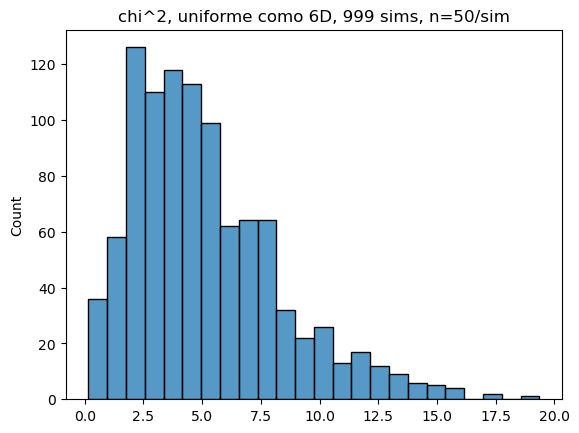

In [7]:
n_exp= sample_size/(high-low)
chi_k= ((n_sims*sample_size-n_exp)**2)/n_exp
print(np.sum(chi_k, axis=1).shape)
sns.histplot(np.sum(chi_k, axis=1)).set(title="chi^2, uniforme como %dD, %d sims, n=%d/sim"%((high-low),iter, sample_size))
plt.show()


Podríamos contar qué porporción de las simulaciones cumple con la tabla $\chi^2$:
- La primera línea nos dice lo esperado (e.g un $90\%$ de las simulaciones deberían $\chi^2$ menor que 9.236 )
- La segunda fila nos dice que porcentaje de nuestras simulaciones lo cumple la condición.

In [8]:
conteo_chi= np.array([np.count_nonzero(np.sum(chi_k, axis=1)<=x_n)/iter for x_n in table])

print("Chi^2 results with %d degrees of fredom"%((high-low)-1))
np.set_printoptions(suppress=True) #suprime la notación exponencial en la tabla 
np.round(np.array(list(zip(1-p,conteo_chi))),3).T


Chi^2 results with 5 degrees of fredom


array([[0.9  , 0.95 , 0.975, 0.99 , 0.995],
       [0.893, 0.939, 0.969, 0.992, 0.997]])

Podríamos contar los estados no visitados por cada iteración (¿$\sim Geo$, $\sim Bin$, $\sim neg\_Bin$?) y preguntarnos para qué *sample_size* tenemos un 95% de las simulaciones con 0 frecencias nulas 

[Text(0.5, 0, 'estados sin vistar'),
 Text(0.5, 1.0, 'histogrma estados sin visitar 6D, 999 sims, n=50/sim')]

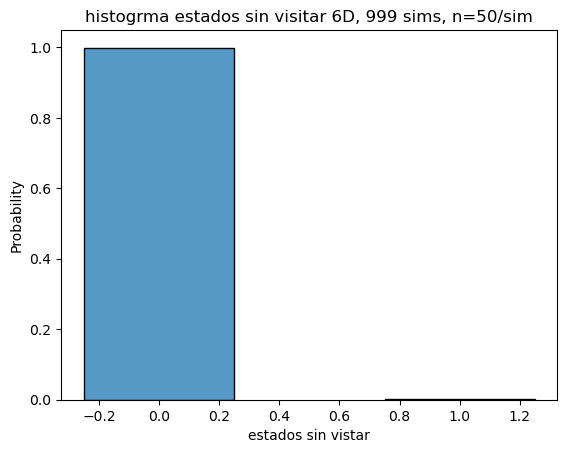

In [9]:
conteo= np.count_nonzero(n_sims==0., axis=1)
hist=sns.histplot(conteo, bins= [1,2,3,4], stat= "probability", discrete=True, shrink=0.5)
hist.set(xlabel="estados sin vistar", title="histogrma estados sin visitar %dD, %d sims, n=%d/sim"%((high-low),iter, sample_size) )

Hagamos ahora un barrido que nos permita saber, dado el limite superior de nuestro sistema/dado (_i.e._ la cantidad de caras del dado, o estados a visitar), qué numero de muestras nos permita decir que el 99% de las simulacioness tiene 0 estados no visitados.

In [20]:
from tqdm.notebook import tqdm

sample_size99=[]
upper_bound=np.arange(7,363,5)
sample_size= 30


for H in tqdm(upper_bound):
    low, high = 1, H
    freq=0.00
        
    while freq < 0.99:
        n_sims=np.stack([every_freq(low, high, size=sample_size, random_state=i) for i in randomState])
        conteo= np.count_nonzero(n_sims==0., axis=1)
        freq= rel_freq(conteo, values=False)[0]
        sample_size += 2
    
    sample_size99.append(sample_size)

  0%|          | 0/72 [00:00<?, ?it/s]

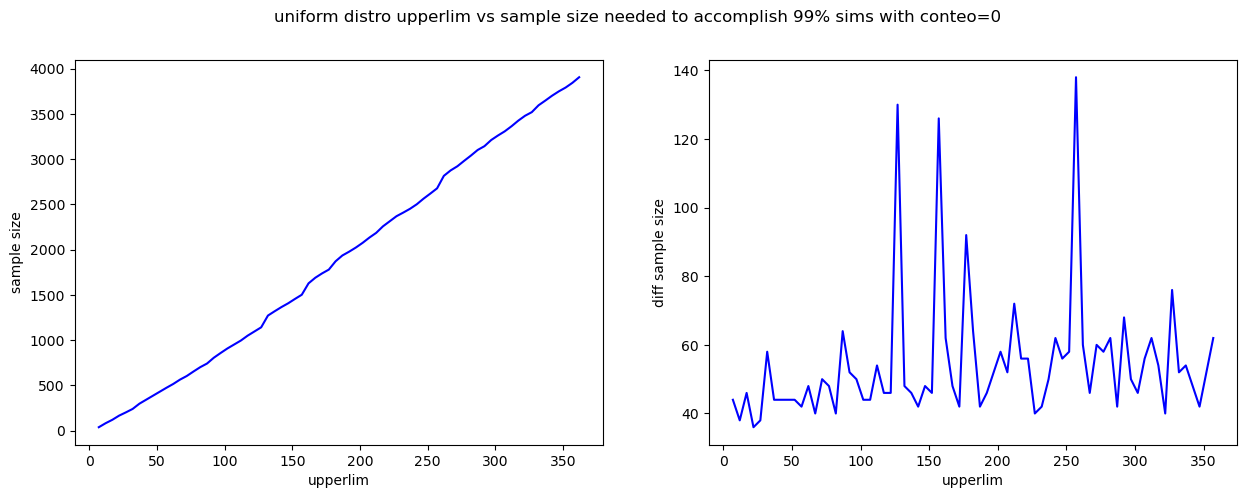

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('uniform distro upperlim vs sample size needed to accomplish 99% sims with conteo=0')

axes[0].plot(upper_bound, sample_size99, 'b-')
axes[0].set_xlabel("upperlim")
axes[0].set_ylabel("sample size")

axes[1].plot(upper_bound[:-1],np.diff(np.array(sample_size99)), 'b-')
axes[1].set_xlabel("upperlim")
axes[1].set_ylabel("diff sample size")

plt.show()